# HGCAL FE studies

### imports and initial setup

In [50]:
#imports and setup

%matplotlib inline
%cd /home/naodell/work/hgcal

import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#from descartes import PolygonPatch
from tqdm import tqdm_notebook

from skhep.modeling import bayesian_blocks
import scripts.helpers as hlp
import scripts.readout_algorithms as algos

import matplotlib
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica Neue') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': 12})


/home/naodell/work/hgcal


### get the data mixtures

In the script `**.py`, I make mixtures of signal and pileup samples.  

In [51]:
gen_list = []
df_list = []
threshold_list = []

#inputdir = 'data/mc_mixtures/qcd_pt15to7000_skim_test'
inputdir = 'data/mc_mixtures/single_electron_pt15_pu200_skim_test'
#inputdir = 'data/mc_mixtures/single_electron_pt35_skim_test'
#inputdir = 'data/mc_mixtures/single_pi_pt25_skim_test'
suffix   = 'el_pt15'

for filename in os.listdir(inputdir):
    data_file = open(f'{inputdir}/{filename}', 'rb')
    threshold = pickle.load(data_file)
    gen = pickle.load(data_file)
    df = pickle.load(data_file)
    
    #if threshold not in [2., 4., 6., 8.]: continue
    
    threshold_list.extend(len(df)*[threshold, ])
    gen_list.extend(gen)
    df_list.extend(df)
    data_file.close()
    
cuts = sorted(list(set(threshold_list)))
algo_list = ['baseline', 
             'threshold_1bx_esort',  'threshold_1bx_nosort', 
             'threshold_8bx_esort',  'threshold_8bx_nosort'
            ]
ratios = {t:{n:[] for n in algo_list} for t in cuts}
effs = {t:{n:[] for n in algo_list[1:]} for t in cuts}
df_effs = {t:pd.DataFrame() for t in cuts}
df_ecounts = {t:[] for t in cuts}
cell_labels = ['zside', 'layer', 'sector', 'panel']
data_list = list(zip(threshold_list, gen_list, df_list))
particle_list = {t:[] for t in set(threshold_list)}
count = 0
for threshold, gpart, data in tqdm_notebook(data_list, total=len(data_list)):
    #print(gpart)
    gen1 = gpart.iloc[0]
    gen2 = gpart.iloc[1]
    denom = gen1.pt
    
    df = data.query('sim_e > 0').copy()
    
    # match simhits to gen particles
    #deta1 = abs(gen1.eta - df.eta)
    #deta2 = abs(gen2.eta - df.eta)
    #
    #dphi1 = abs(df.phi - gen1.phi)
    #dphi1[dphi1 > np.pi] = 2*np.pi - dphi1
    #dphi2 = abs(df.phi - gen1.phi)
    #dphi2[dphi2 > np.pi] = 2*np.pi - dphi2
    #
    #df = df[((dphi1 < 0.2) & (deta1 < 0.05)) | ((dphi2 < 0.2) & (deta2 < 0.05))]
    
    #denom = df.groupby('zside').sum()['sim_e']
    #print(gen1.e, gen2.e)
    
    #print(denom)
    #print(df.groupby('zside').sum()[['reco_e', 'sim_e', 'pt']])
    
    n_simhits = df.shape[0]
    if n_simhits == 0:
        continue
        
    df['baseline'] = np.ones(n_simhits)
    for algo in algo_list:
        df_algo = df
        if algo != 'baseline':
            df_algo = df.query(f'{algo}')
            effs[threshold][algo].append(df_algo.shape[0]/n_simhits)
            #print(algo, df_algo.shape[0], n_simhits)

        
        sumpt = df_algo.groupby('zside').sum()['pt']
        r = sumpt/denom
        ratios[threshold][algo].append(r.values)
        #print(algo, r.values)
        
    df[algo_list] = df[algo_list].astype(float).multiply(df['reco_e'], axis=0)
    df_counts = df.groupby(['layer', 'panel']).sum()[algo_list]
    if df_effs[threshold].empty:
        df_effs[threshold] = df_counts
    else:
        df_effs[threshold] = df_effs[threshold].add(df_counts, fill_value=0)
        
    #print('')
    particle_list[threshold].append(np.array([gen1.pt, abs(gen1.eta)]))

HBox(children=(IntProgress(value=0, max=20000), HTML(value='')))

In [52]:
# rearrange data
particle_list = {t:np.vstack(pl) for t, pl in particle_list.items()}
ratios = {t:{pt:np.concatenate(d2) for pt, d2 in d1.items()} for t, d1 in ratios.items()}

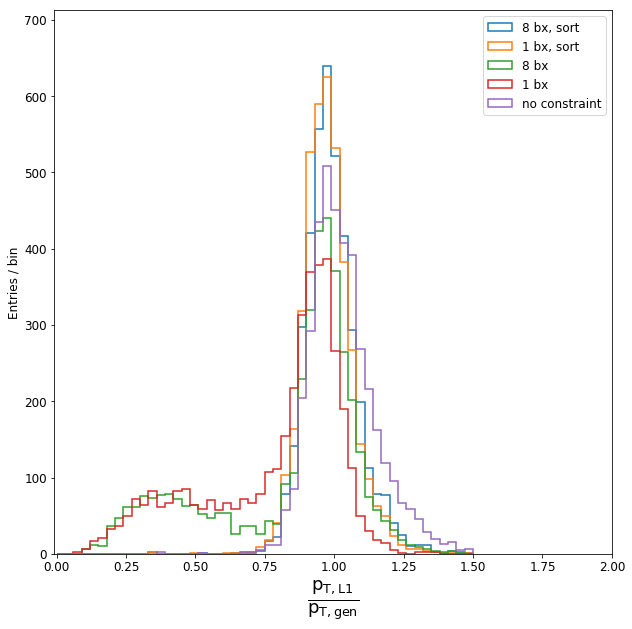

In [53]:
# mip_pt > 2 histograms
fig = plt.figure(figsize=(10, 10), facecolor='white')

ax = plt.subplot()
n_bins = 50
ax.hist(ratios[cuts[0]]['threshold_8bx_esort'], bins=n_bins, range=[0, 1.5], linewidth=1.5, histtype='step')
ax.hist(ratios[cuts[0]]['threshold_1bx_esort'], bins=n_bins, range=[0, 1.5], linewidth=1.5, histtype='step')
ax.hist(ratios[cuts[0]]['threshold_8bx_nosort'], bins=n_bins, range=[0, 1.5], linewidth=1.5, histtype='step')
ax.hist(ratios[cuts[0]]['threshold_1bx_nosort'], bins=n_bins, range=[0, 1.5], linewidth=1.5, histtype='step')
h, b, _ = ax.hist(ratios[cuts[0]]['baseline'], bins=n_bins, range=[0, 1.5], linewidth=1.5, histtype='step')

ax.set_xlim(-0.01, 2.)
ax.set_ylim(0, 1.4*np.max(h))
ax.set_xlabel(r'$\sf \frac{p_{T,L1}}{p_{T,gen}}$', fontsize=26)
ax.set_ylabel('Entries / bin')

labels = ['8 bx, sort', '1 bx, sort', '8 bx', '1 bx', 'no constraint']
#labels = ['8 bx, sort', '8 bx', 'no constraint']
ax.legend(labels)

plt.savefig(f'plots/threshold_algo_resolution_{suffix}.pdf')
plt.show()

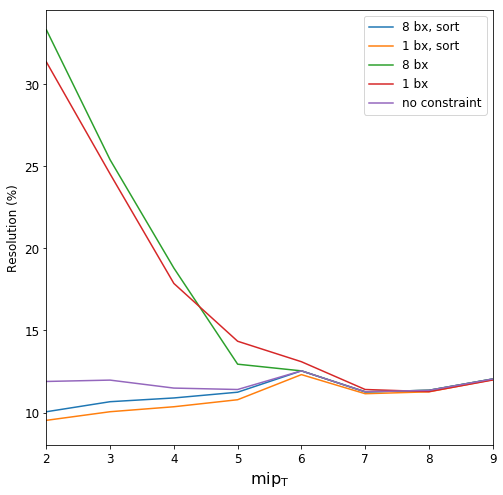

In [54]:
# mip_pt resolution scans
resolutions = {a:[100*ratios[c][a].std()/ratios[c][a].mean() for c in cuts] for a in algo_list}

fig, ax = plt.subplots(1, 1, figsize=(8, 8), facecolor='white')
ax.plot(cuts, resolutions['threshold_8bx_esort'])
ax.plot(cuts, resolutions['threshold_1bx_esort'])
ax.plot(cuts, resolutions['threshold_8bx_nosort'])
ax.plot(cuts, resolutions['threshold_1bx_nosort'])
ax.plot(cuts, resolutions['baseline'])

ax.set_xlim(2, 9.)
ax.set_xlabel(r'$\sf mip_{T}$', fontsize=16)
ax.set_ylabel('Resolution (%)')

labels = ['8 bx, sort', '1 bx, sort', '8 bx', '1 bx', 'no constraint']
ax.legend(labels)

plt.savefig(f'plots/resolution_mip_scan_{suffix}.pdf')
plt.show()

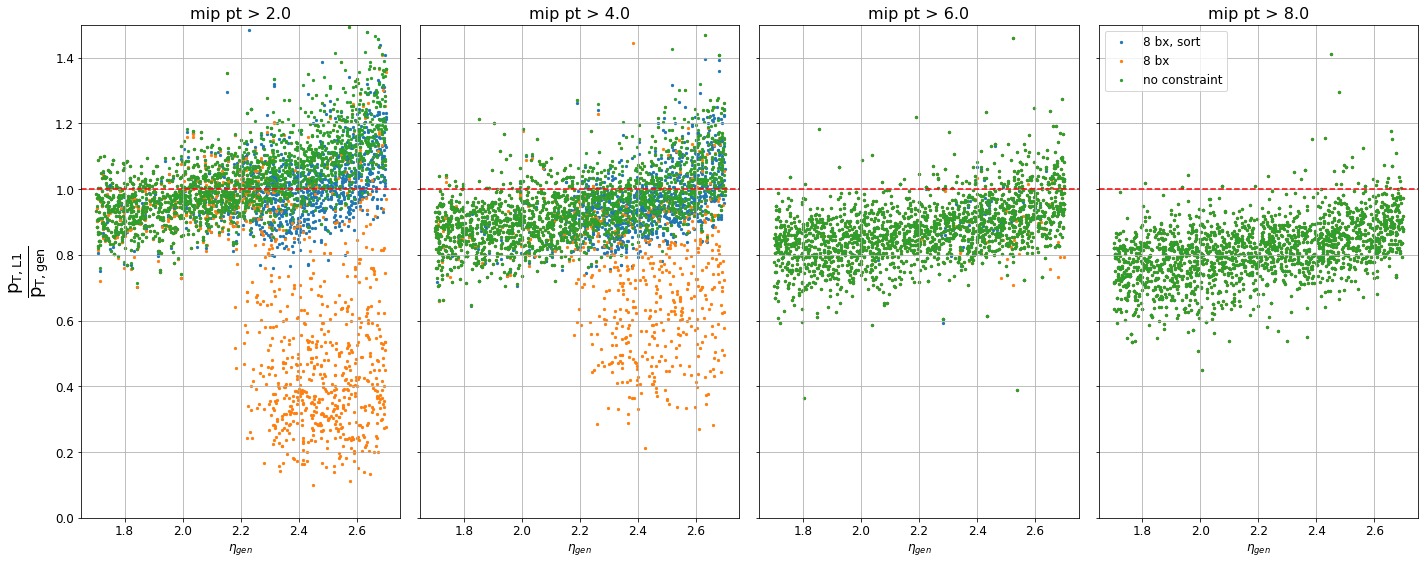

In [55]:
#
fig, axes = plt.subplots(1, 4, figsize=(20, 8), facecolor='white', sharey=True)

#for i, c in enumerate(cuts[1::2]):
for i, c in enumerate([2., 4., 6., 8.]):
    ax = axes[i]
    x = particle_list[c][:,1]
    y = ratios[c]['threshold_8bx_esort'][::2]
    ax.scatter(x, y, s=5)
    
    y = ratios[c]['threshold_8bx_nosort'][::2]
    ax.scatter(x, y, s=5)
    
    y = ratios[c]['baseline'][::2]
    ax.scatter(x, y, s=5)
    
    ax.plot([1.65, 2.75], [1., 1.], 'r--', label='_nolegend_')
    
    ax.set_title(f'mip pt > {c}')
    ax.set_xlabel(r'$\eta_{gen}$')
    ax.set_xlim([1.65, 2.75])
    ax.set_ylim([0., 1.5])
    ax.grid()
    if i == 0:
        ax.set_ylabel(r'$\sf \frac{p_{T,L1}}{p_{T,gen}}$', fontsize=26)
    if i == 3:
        #labels = ['8 bx, sort', '1 bx, sort', '8 bx', '1 bx', 'no constraint']
        labels = ['8 bx, sort', '8 bx', 'no constraint']
        ax.legend(labels)
        break

plt.savefig(f'plots/res_vs_eta_{suffix}.pdf')
plt.tight_layout()
plt.show()

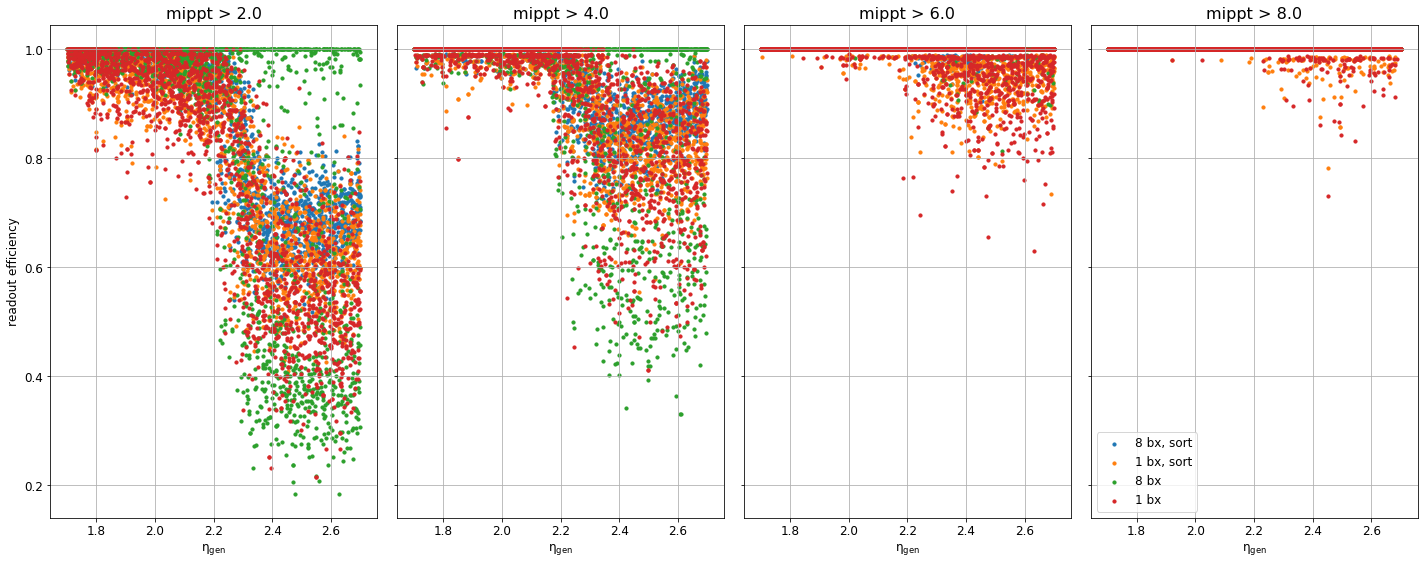

In [56]:
#
fig, axes = plt.subplots(1, 4, figsize=(20, 8), facecolor='white', sharey=True)

for i, c in enumerate([2.0, 4.0, 6.0, 8.0]):
    ax = axes[i]
    ax.scatter(particle_list[c][:,1], effs[c]['threshold_8bx_esort'], s=10)
    ax.scatter(particle_list[c][:,1], effs[c]['threshold_1bx_esort'], s=10)
    ax.scatter(particle_list[c][:,1], effs[c]['threshold_8bx_nosort'], s=10)
    ax.scatter(particle_list[c][:,1], effs[c]['threshold_1bx_nosort'], s=10)

    ax.set_xlabel(r'$\sf \eta_{gen}$')
    ax.set_title(f'mippt > {c}')
    if i == 0:
        ax.set_ylabel('readout efficiency')
    if i == 3:
        labels = ['8 bx, sort', '1 bx, sort', '8 bx', '1 bx']
        #labels = ['8 bx, sort', '8 bx']
        ax.legend(labels)
    ax.grid()

plt.savefig(f'plots/eff_vs_eta_{suffix}.pdf')
plt.tight_layout()
plt.show()

# eta-dependent mippt thresholds

From inspecting the $\eta$ dependence of the resolution for the various algorithms, it would appear that all algorithms show an improvement when the mip pt threshold is increased for the higher $\eta$ panels.

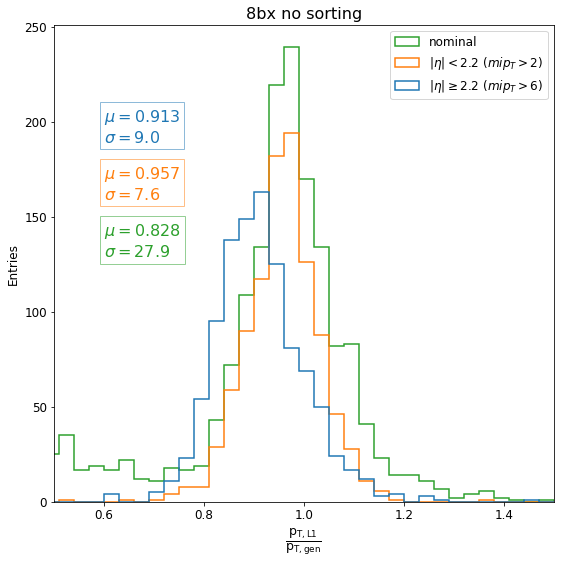

In [57]:
#
fig, axes = plt.subplots(1, 1, figsize=(8, 8), facecolor='white', sharey=True)

# split samples at eta = 2.2
c_low, c_high = 2.0, 6.0
peta_low, peta_high = particle_list[c_low][:,1], particle_list[c_high][:,1]
mask = peta_high >= 2.2
r_eta_plus  = ratios[c_high]['threshold_8bx_nosort'][::2][peta_high >= 2.2]
r_eta_minus = ratios[c_low]['threshold_8bx_nosort'][::2][peta_low < 2.2]
r_nominal = ratios[c_low]['threshold_8bx_nosort'][::2]

offset_plus, offset_minus, offset_nominal = r_eta_plus.mean(), r_eta_minus.mean(), r_nominal.mean()

axes.hist([r_eta_plus, r_eta_minus, r_nominal], bins=n_bins, range=[0, 1.5], linewidth=1.5, histtype='step')
axes.set_xlim([0.5, 1.5])

stmp = r'$\mu = {0:.3f}$'.format(offset_plus) + '\n' + '$\sigma = {0:.1%}%$'.format(r_eta_plus.std())
axes.text(0.6, 190., stmp, fontdict=dict(color='C0', size=16),  bbox=dict(color='C0', alpha=0.5, fill=False))
stmp = r'$\mu = {0:.3f}$'.format(offset_minus) + '\n' + '$\sigma = {0:.1%}%$'.format(r_eta_minus.std())
axes.text(0.6, 160., stmp, fontdict=dict(color='C1', size=16),  bbox=dict(color='C1', alpha=0.5, fill=False))
stmp = r'$\mu = {0:.3f}$'.format(offset_nominal) + '\n' + '$\sigma = {0:.1%}%$'.format(r_nominal.std())
axes.text(0.6, 130., stmp, fontdict=dict(color='C2', size=16),  bbox=dict(color='C2', alpha=0.5, fill=False))

axes.set_title('8bx no sorting')
axes.set_ylabel('Entries')
axes.set_xlabel(r'$\sf \frac{p_{T,L1}}{p_{T,gen}}$', fontsize=18)
axes.legend(['nominal', r'$|\eta| < 2.2\ (mip_{T} > 2)$', r'$|\eta| \geq 2.2\ (mip_{T} > 6)$'])

plt.tight_layout()
plt.savefig(f'plots/test_readout_resolution_{suffix}.pdf')
plt.show()


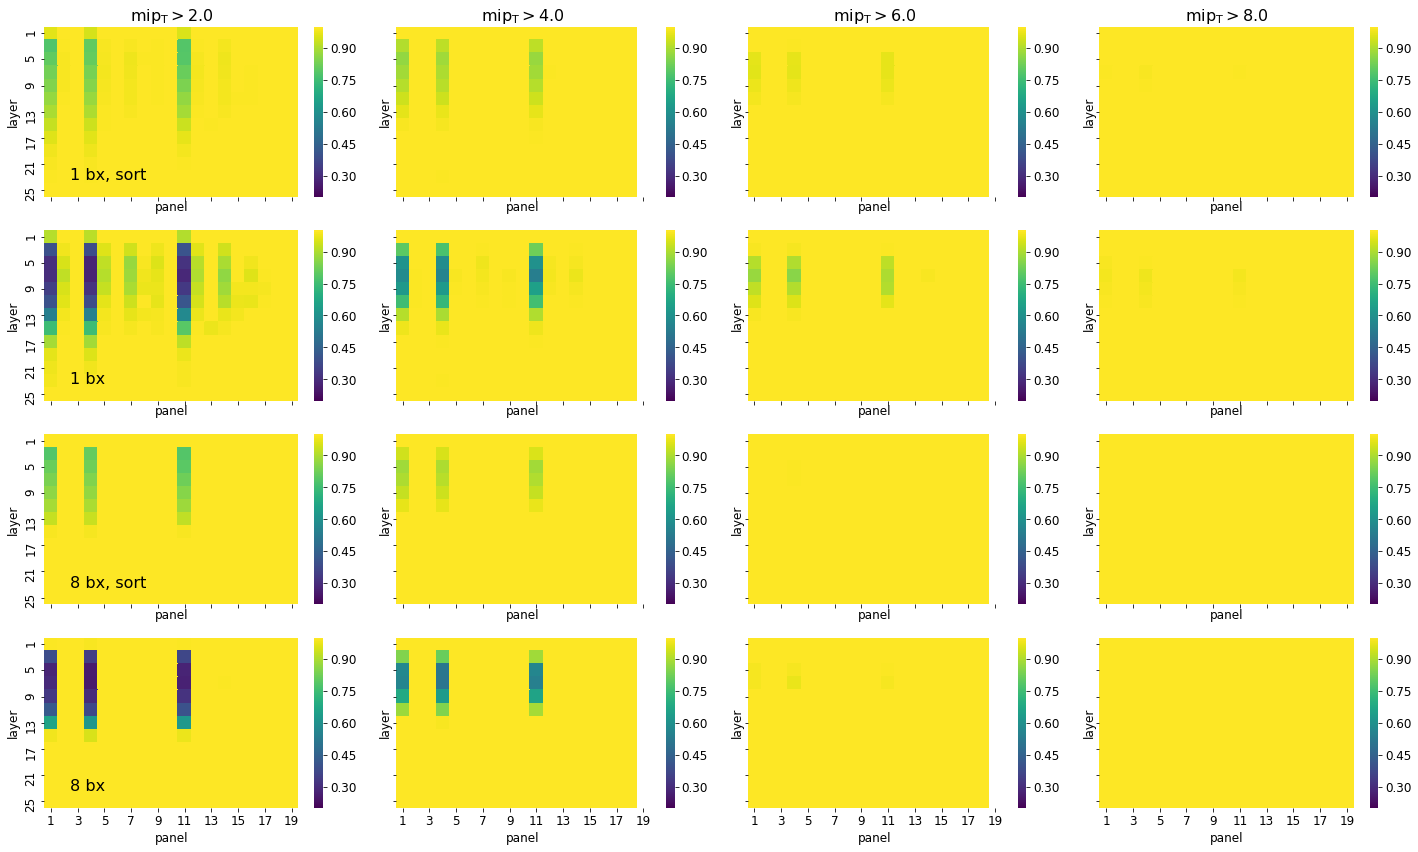

In [59]:
# efficiency by layer, panel, and mippt threshold

import seaborn as sns

fig, axes = plt.subplots(4, 4, figsize=(20, 12), facecolor='white', sharex=True, sharey=True)
labels = ['1 bx, sort', '1 bx', '8 bx, sort', '8 bx']
for i, algo in enumerate(algo_list[1:]):
    for j, c in enumerate([2.0, 4.0, 6.0, 8.0]):
        ax = axes[i][j]
        eff = df_effs[c][algo]/df_effs[c]['baseline']
        eff = eff.unstack(fill_value=1).loc[:25, :19]
        sns.heatmap(eff, ax=ax, vmin=0.2, vmax=1, cmap='viridis')
        
        if i == 0:
            ax.set_title(r'$\sf mip_{T} >$' + f'{c}')
        if j == 0:
            ax.text(0.1, 0.1, labels[i], transform=ax.transAxes, fontsize=16)

plt.tight_layout()
plt.savefig(f'plots/big_efficiency_{suffix}.pdf')
plt.show()